In [46]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel
from transformers import AutoTokenizer, CLIPTextModelWithProjection
from transformers import AutoProcessor, CLIPVisionModelWithProjection
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scipy.stats as st 
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import pickle
from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances

In [53]:
pickle_file_path = "embeds_cifar100.pkl"
data = pickle.load(open(pickle_file_path, 'rb'))
image_embeds = data["image_embeds"]
y_real = data["y_real"]
text_embeds = data["text_embeds"]
templates = data["templates"]
texts = data["texts"]
classes = data["classes"]


In [54]:
def class_rep(X, y):
    X_ = []
    y_ = []
    for c in set(list(y)):
        X_.append(np.mean (X[y==c], axis=0))
        y_.append(c)
    return np.array(X_), np.array(y_).reshape( (-1, 1))



In [55]:
def nearest_neighbors(x, self_is_neighbor = False):
    D = pairwise_distances(x, x, metric='cosine')
    if self_is_neighbor == False:
        np.fill_diagonal(D, np.inf)
    closest = np.argsort(D, axis=1)
    return closest

def mean_neighborhood_similarity(A, B, k):
    """
    This is $D_g(A, B, k)$
    """
    nx = nearest_neighbors(A)
    ny = nearest_neighbors(B)
    inter = 0
    for i in range(A.shape[0]):
        sx = set(nx[i, 0:k])
        sy = set(ny[i, 0:k])
        inter += len(sx.intersection(sy))/len(sx.union(sy)) # Jaccard distance
    inter /= A.shape[0]
    return inter

def mean_neighborhood_distance(A, B, k):
    """
    This is $D_g(A, B, k)$
    """
    inter = 1-mean_neighborhood_similarity(A,B,k)
    return inter

def mean_structural_distance(A, B):
    """
    This is $S_g(A, B)$
    """
    k_vals = np.array(list(range(1, A.shape[0]-1)))
    ns = np.array([mean_neighborhood_distance(A, B, k) for k in k_vals])
    
    msd = np.max((1-ns))
    return msd

In [56]:
# Plot of a real-life case
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
print(X.shape)
dgs = []
labels = []
ks = list(range(1, len(y)))
for i in tqdm(range(len(templates))):
    labels.append(templates[i])
    dg = []
    Z = text_embeds[i::len(templates),:]
    for idx, k in enumerate(ks):
        sg = mean_neighborhood_similarity(X, Z, k)
        dg.append(sg)
      
    dgs.append(dg)        

(100, 512)


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:06<00:00,  2.80it/s]


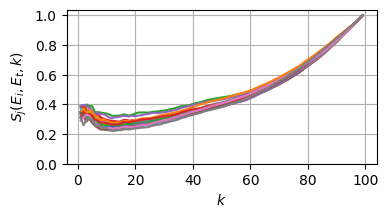

In [58]:
plt.figure(figsize=(4,2))

plt.plot(ks, np.array(dgs).T, '-', label=templates)
#plt.scatter( ks[np.argmax(res)], np.max(res), label='$S_g(A,B)$', c='r')
#plt.title(f'$d$ for different $k$. samples={n_samples}, SNR={np.round(SNR,2)}dB' )
plt.xlabel('$k$')
plt.ylabel('$S_j(E_i, E_t, k)$')
#plt.legend(ncol=4)
plt.savefig('dabk_clip.pdf', bbox_inches='tight')
#plt.xlim([0,5])
#plt.ylim([0, 1])
#plt.semilogx()
#plt.semilogy()
a = 0.2
plt.yticks(np.arange(0,1+a, a))

plt.grid()
plt.show()

# Plot with limit curve

In [70]:
# Limit curve
n_samples = X.shape[0]
ks = list(range(1, n_samples))
dim = X.shape[1]
repetitions = 30

res = []
for k in tqdm(ks):
    this_res = []
    for r in range(repetitions):
        if k == 0:
            res.append(0)
            continue

        x = np.random.randn( n_samples, dim)
        y = np.random.randn(n_samples, dim)
        this_res.append(mean_neighborhood_similarity(x, y, k))
    res.append( np.mean(this_res) )
res = np.array(res)


100%|██████████| 99/99 [00:19<00:00,  5.10it/s]


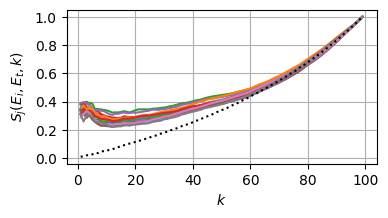

In [71]:
plt.figure(figsize=(4,2))

plt.plot(ks, np.array(dgs).T, '-', label=templates)
plt.plot(ks, res, 'k:')
plt.xlabel('$k$')
plt.ylabel('$S_j(E_i, E_t, k)$')


#plt.savefig('dabk_clip.pdf', bbox_inches='tight')

a = 0.2
plt.yticks(np.arange(0,1+a, a))

plt.grid()
plt.show()

(18, 99)


/tmp/ipykernel_3268424/2227915627.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(ks, (np.array(dgs).T - res_.T)/(1-res_.T), '-', label=templates)


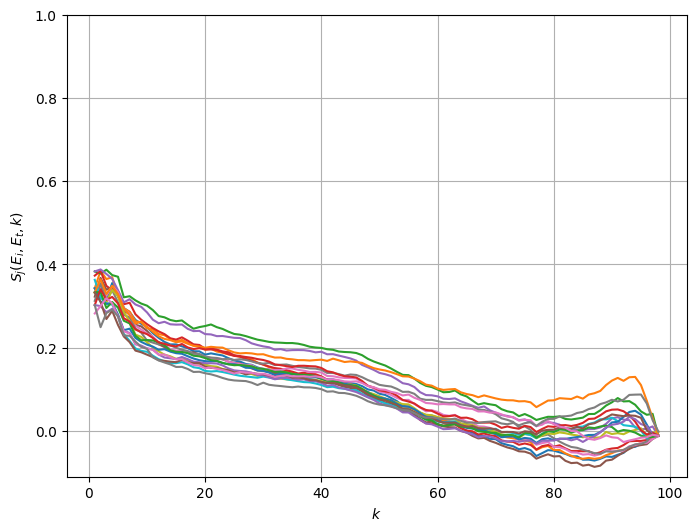

In [87]:
plt.figure(figsize=(8,6))
res_aux = res.reshape( (1,-1) )
res_ = np.repeat(res_aux,np.array(dgs).shape[0],axis=0)
print(res_.shape)

plt.plot(ks, (np.array(dgs).T - res_.T)/(1-res_.T), '-', label=templates)
plt.xlabel('$k$')
plt.ylabel('$S_j(E_i, E_t, k)$')


#plt.savefig('dabk_clip.pdf', bbox_inches='tight')

a = 0.2
plt.yticks(np.arange(0,1+a, a))

plt.grid()
plt.show()

In [23]:
# Prompt engineering
import scipy.stats as st

k = 15
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
acc = []
jdist = []
ks = []
for i in range(len(templates)):
    Z = text_embeds[i::len(templates),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    sg = mean_neighborhood_similarity(X, Z, k)
    #print(sg)
    #print(p)
    jdist.append(sg)


print(st.pearsonr(jdist, acc))


PearsonRResult(statistic=0.4914446447169542, pvalue=0.038333667204535356)


In [25]:

X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
acc = []
jdist = []
for i in range(len(templates)):
    Z = text_embeds[i::len(templates),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    #dg = mean_neighborhoood_distance(X, Z, 5)
    dg = mean_neighborhood_similarity(X, Z, k)
    jdist.append(dg)

print(st.pearsonr(jdist, acc))
print(st.spearmanr(jdist, acc))

PearsonRResult(statistic=0.4914446447169542, pvalue=0.038333667204535356)
SignificanceResult(statistic=0.587203302373581, pvalue=0.010402557727151924)


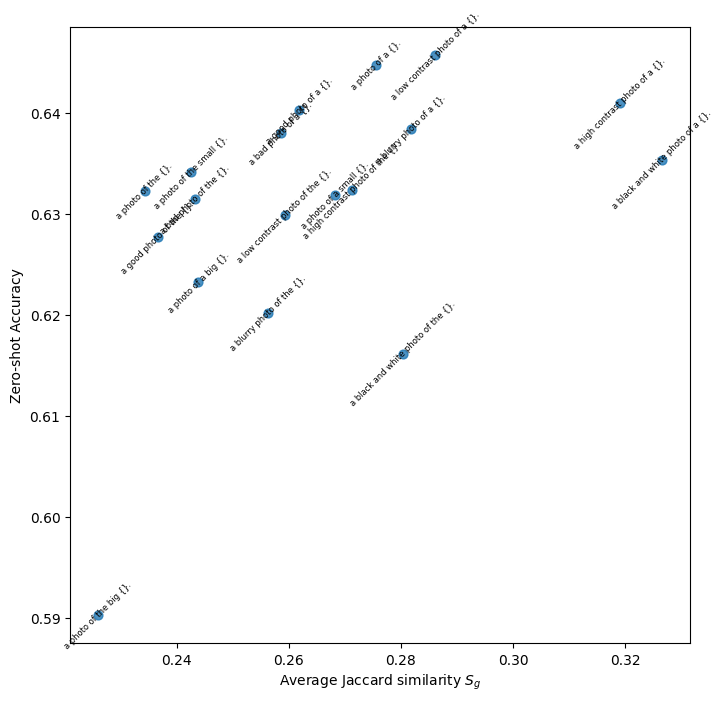

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(jdist, acc, s=40, alpha=0.8)
for i in range(len(templates)):
    plt.text(jdist[i], acc[i], templates[i], fontsize=6, ha='center', va='center', rotation=45)
    #plt.text(jdist[i], acc[i]-0.01, ks[i], fontsize=8, ha='center', va='top')
plt.xlabel('Average Jaccard similarity $S_g$')
plt.ylabel('Zero-shot Accuracy')
plt.savefig('zeroshot_sg.pdf', bbox_inches='tight')
plt.show()

# With weird templates

In [41]:
templates_ = [
    'No, Luke. I AM your {}.',
    'Not a {}.',
    'The sound of a {}.',
    'Feel the power of a {}.',
    'Born to be {}.',
    'Hasta la vista, {}!',
    'I am feeling supersonic, give me {} and tonic.',
    'LOL {} is SO random!',
    'Perhaps {} could help us save Robin from The Joker.',
    'The wheels on the {} go round and round.',
    'We all live in a yellow {}',
    '{}.',
    'I like {}',
    'I cant find the {} here.',
    'Most {} are good-looking.',
    'You are a {}, Harry!',
    'AND MY {}!',
    'We must take the {} to Mordor!',
]

n_new = len(templates_)

texts_ = []
templates_ += templates
for c in classes:    
    for t in templates_:
        texts_.append(t.format(c))



In [34]:
# Get text embeddings
model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
inputs = tokenizer(texts_, padding=True, return_tensors="pt")
outputs = model(**inputs)
text_embeds_ = outputs.text_embeds.detach().numpy()

In [35]:
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
acc = []
jdist = []
for i in range(len(templates_)):
    Z = text_embeds_[i::len(templates_),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    dg = mean_neighborhood_similarity(X, Z, k)
    jdist.append(dg)

print(st.pearsonr(jdist, acc))
print(st.spearmanr(jdist, acc))

PearsonRResult(statistic=0.8071745656797289, pvalue=2.7327145657379577e-09)
SignificanceResult(statistic=0.8671814671814673, pvalue=7.880793746361374e-12)


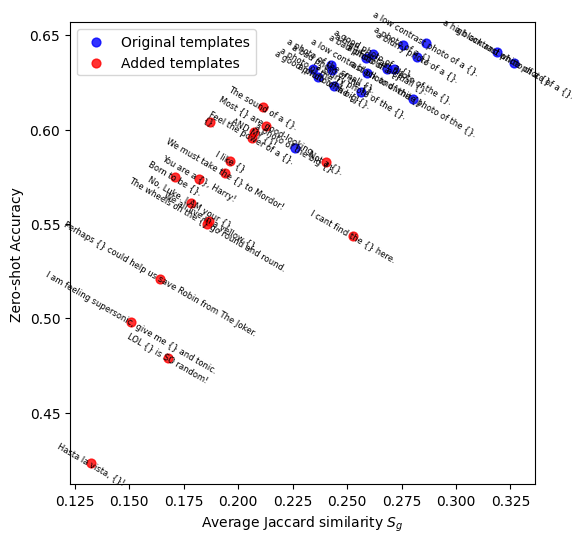

In [45]:
plt.figure(figsize=(6,6))
plt.scatter(jdist[n_new:], acc[n_new:], s=40, alpha=0.8, c='b', label='Original templates')
plt.scatter(jdist[:n_new], acc[:n_new], s=40, alpha=0.8, c='r', label='Added templates')
for i in range(len(templates_)):
    plt.text(jdist[i], acc[i], templates_[i], fontsize=6, ha='center', va='center', rotation=-30)
    #plt.text(jdist[i], acc[i]-0.01, ks[i], fontsize=8, ha='center', va='top')
plt.xlabel('Average Jaccard similarity $S_g$')
plt.ylabel('Zero-shot Accuracy')
plt.savefig('zeroshot_sg_dirty.pdf', bbox_inches='tight')
plt.legend()
plt.show()